# Modeling of mock data from SLITronomy paper

In this notebook we interested in fitting simulated lens systems from [Galan et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...647A.176G/abstract). One goal is to compare source reconstructions. Another one is to fit _all_ parameters, i.e. including lens parameters (SIE, external shear), instead of assuming those to be perfectly known like for SLITronomy.

We employ the following _automated_ strategy, each time using knowledge from previous step to refine the model:

1. fit all parameters with smooth profiles only (lens and source), from parameters typically far from the truth;
2. fix lens parameters, and fit the source on a wavelet-regularized pixel grid;
3. fit all at once, both smooth lens parameters and pixelated source.

We can proceed to an additional interesting test: can residuals from step 1 above be abosorbed in perturbations to the lens potential instead?

3. (bis) fix all smooth parameters (lens and smooth), and fit for pixelated potential perturbations in the lens.

__last updated__: 04/08/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
import copy
from pprint import pprint
import pickle as pkl
import time
from matplotlib.colors import LogNorm
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Analysis.plot import Plotter

# Universal font size
FS = 18

# Global settings
max_iterations = 500
init_learning_rate = 1e-2

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-2, flux_vmax=3e0)

In [2]:
# select the type of source: 'single' or 'group'
source_type = 'group'

### Data grids

In [3]:


pkl_filename = f'slitronomy-mock_mocksource-highres-{source_type}_ssres-3.pkl'
#pkl_filename = f'slitronomy-mock_mocksource-highres-{source_type}_ssres-3.pkl'
with open(os.path.join('data', 'SLITronomy', pkl_filename), 'rb') as f:
    mock_alldata = pkl.load(f)

class_list, kwargs_true_lens, kwargs_true_source, source_sim_comp, source_sim_data_res = mock_alldata
data_class, psf_class = class_list
data = data_class.data

npix, npix_y = data_class.num_pixel_axes
pix_scl = data_class.pixel_width  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# update plotter with data and true source arrays
plotter.set_data(data)
plotter.set_true_source(source_sim_data_res)

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

# supersampling?
kwargs_numerics = {'supersampling_factor': 2, 'convolution_type': 'grid'}

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.9599999999999995, 3.9599999999999995) arcsec
y range    : (-3.9599999999999995, 3.9599999999999995) arcsec


### Visualize data

-0.1761294535083189


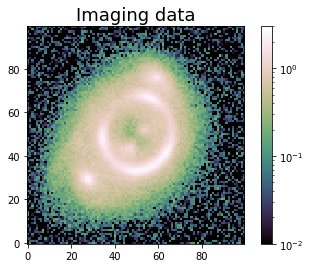

In [4]:
print(data.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plt.colorbar()
plt.show()

### Noise

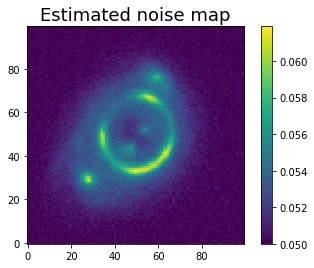

In [5]:
# here we know the true exposure time and background noise level
kwargs_noise = {'background_rms': data_class.background_rms, 
                'exposure_time': data_class.exposure_map}
noise = Noise(npix, npix, **kwargs_noise)
noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
#plt.imshow(np.sqrt(data_class.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

In [6]:
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_class.kernel_point_source}
psf = PSF(**kwargs_psf)

## 1) Analytical lens + analytical smooth source modeling

Here we choose only smooth profile for a first rough model.

### Define modeling choices and initial parameter values

In [7]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

# Create the model
lens_image_allsmooth = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'amp': 20., 'R_sersic': 0.8, 'n_sersic': 2., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_allsmooth = Parameters(lens_image_allsmooth, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true_approx_smooth = {'kwargs_lens': kwargs_true_lens, 'kwargs_source': copy.deepcopy(kwargs_init['kwargs_source']), 'kwargs_lens_light': []}
p_true_approx_smooth = copy.deepcopy(parameters_allsmooth.kwargs2args(kwargs_true_approx_smooth))
param_names = parameters_allsmooth.names
print("truths:", p_true_approx_smooth, param_names, len(p_true_approx_smooth))

print("prior types:", parameters_allsmooth.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_allsmooth.bounds)

truths: [1.33084116e+00 1.11111111e-01 0.00000000e+00 3.00000000e-02
 7.85398163e-01 2.00000000e+01 8.00000000e-01 2.00000000e+00
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03] ['theta_E', 'e1', 'e2', 'gamma_ext', 'psi_ext', 'amp', 'R_sersic', 'n_sersic', 'e1', 'e2', 'center_x', 'center_y'] 12
prior types: [None, None, None, None, None, None, None, None, None, None, None, None]
lower/upper bounds (for uniform priors): [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf inf inf inf inf]


### Visualise initial model

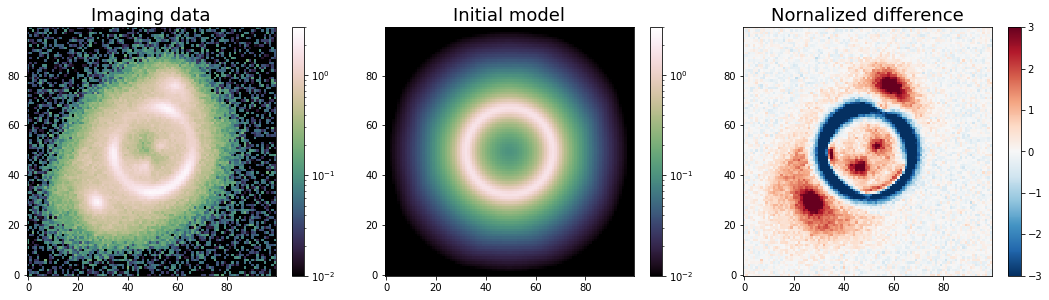

In [8]:
init_model = lens_image_allsmooth.model(**kwargs_init)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Imaging data", fontsize=FS)
img = ax.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[1]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(init_model, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[2]
ax.set_title("Nornalized difference", fontsize=FS)
img = ax.imshow(data/data.mean()-init_model/init_model.mean(), origin='lower', cmap='RdBu_r', vmin=-3, vmax=3)
fig.colorbar(img, ax=ax)
fig.tight_layout()

### Optimize parameters

In [9]:
loss_allsmooth = Loss(data, lens_image_allsmooth, parameters_allsmooth, likelihood_type='chi2')
optimizer_allsmooth = Optimizer(loss_allsmooth, parameters_allsmooth)
print(optimizer_allsmooth.loss(p_true_approx_smooth))

23.95704937719185


In [10]:
# Optimise !
best_fit, logL, extra_fields, runtime \
    = optimizer_allsmooth.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final_allsmooth = copy.deepcopy(parameters_allsmooth.best_fit_values(as_kwargs=True))
pprint(kwargs_final_allsmooth)
#print(extra_fields['result_class'])  # uncomment for full scipy summary

Runtime: 17.673940896987915
{'kwargs_lens': [{'center_x': 0.0,
                  'center_y': 0.0,
                  'e1': array(0.29321506),
                  'e2': array(-0.06989595),
                  'theta_E': array(1.39195314)},
                 {'dec_0': 0.0,
                  'gamma_ext': array(0.06271812),
                  'psi_ext': array(0.03753707),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [],
 'kwargs_source': [{'R_sersic': array(2.38573122),
                    'amp': array(21.66752834),
                    'center_x': array(0.06966888),
                    'center_y': array(0.12975427),
                    'e1': array(-0.13721988),
                    'e2': array(0.30963435),
                    'n_sersic': array(1.9039249)}]}


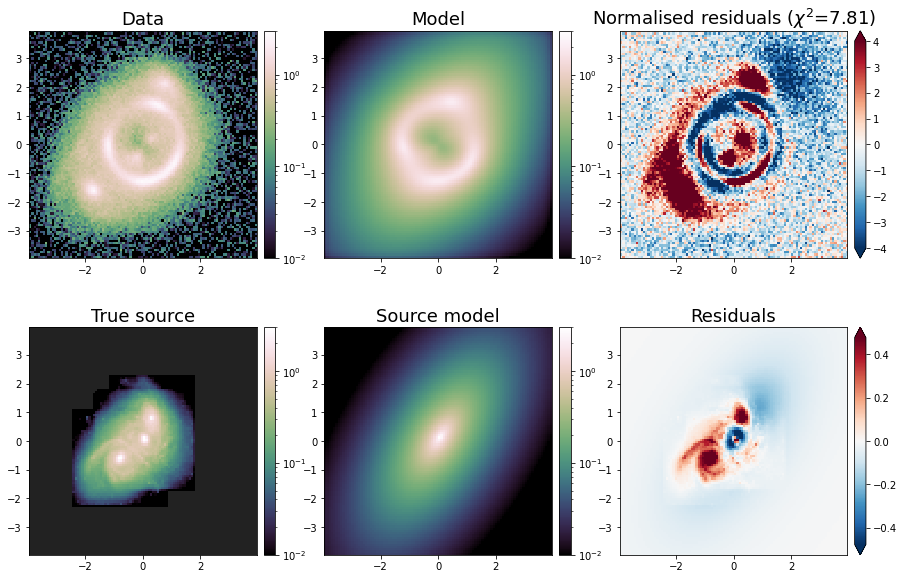

In [11]:
plotter.model_summary(lens_image_allsmooth, kwargs_final_allsmooth)

In [12]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_true_lens):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
    #for i, params in enumerate(kwargs_source_light):
    #    for key, value in params.items():
    #        fit = kwargs['kwargs_source'][i][key]
    #        _print_error(key, value, fit)
        
print_errors(kwargs_final_allsmooth)

print("\nSource parameters\n-----")
pprint(kwargs_final_allsmooth['kwargs_source'][0])

Error
-----
theta_E:   4.59 % (1.330841155341295 => 1.391953139696102)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        163.89 % (0.11111111111111108 => 0.2932150568176884)
e2:        0.07 [abs] (0.0 => -0.06989594699184563)
gamma_ext: 109.06 % (0.03 => 0.06271811773597713)
psi_ext:   95.22 % (0.7853981633974483 => 0.037537065922572416)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)

Source parameters
-----
{'R_sersic': array(2.38573122),
 'amp': array(21.66752834),
 'center_x': array(0.06966888),
 'center_y': array(0.12975427),
 'e1': array(-0.13721988),
 'e2': array(0.30963435),
 'n_sersic': array(1.9039249)}


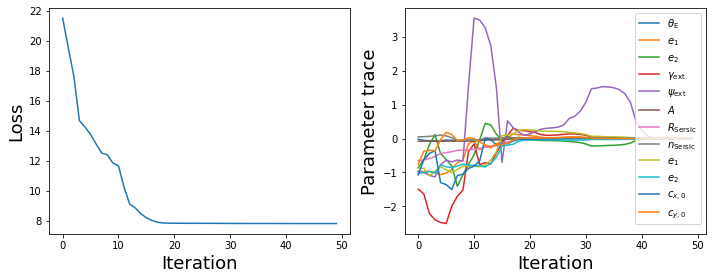

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer_allsmooth.loss_history)), optimizer_allsmooth.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer_allsmooth.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer_allsmooth.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters_allsmooth.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

## 2) Pixelated source modeling with fixed smooth lens

Here we optimise the source light on a grid of wavelet-regularized pixels, fixing the lens parameters to their previous values

In [14]:
# Source light
source_light_model_list = ['PIXELATED']
source_light_model = LightModel(source_light_model_list, pixel_interpol='bilinear',
                                pixel_x_coords=x_coords, pixel_y_coords=y_coords)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

lens_image_pixsource = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'image': 1e-8 * jnp.ones_like(data)}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource = Parameters(lens_image_pixsource, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true = {'kwargs_lens': kwargs_true_lens, 
                 'kwargs_source': [{'image': source_sim_data_res}],
                 'kwargs_lens_light': []}
p_true = copy.deepcopy(parameters_pixsource.kwargs2args(kwargs_true))
param_names = parameters_pixsource.names
print(p_true, param_names[0], param_names[-1], len(p_true))

print("prior types:", parameters_pixsource.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixsource.bounds)

[0. 0. 0. ... 0. 0. 0.] s_0 s_9999 10000
prior types: [None]
lower/upper bounds (for uniform priors): [-inf] [inf]


In [15]:
loss_pixsource = Loss(data, lens_image_pixsource, parameters_pixsource, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source'], 
                      regularization_strengths=[3, 3, 3])
optimizer_pixsource = Optimizer(loss_pixsource, parameters_pixsource)
print(loss_pixsource(p_true))

5.567938225071834


In [16]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixsource.optax(max_iterations=max_iterations, 
                                init_learning_rate=init_learning_rate,
                                restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_pixsource = parameters_pixsource.best_fit_values(as_kwargs=True)

Runtime: 22.65053081512451 s
Final loss: 2.53


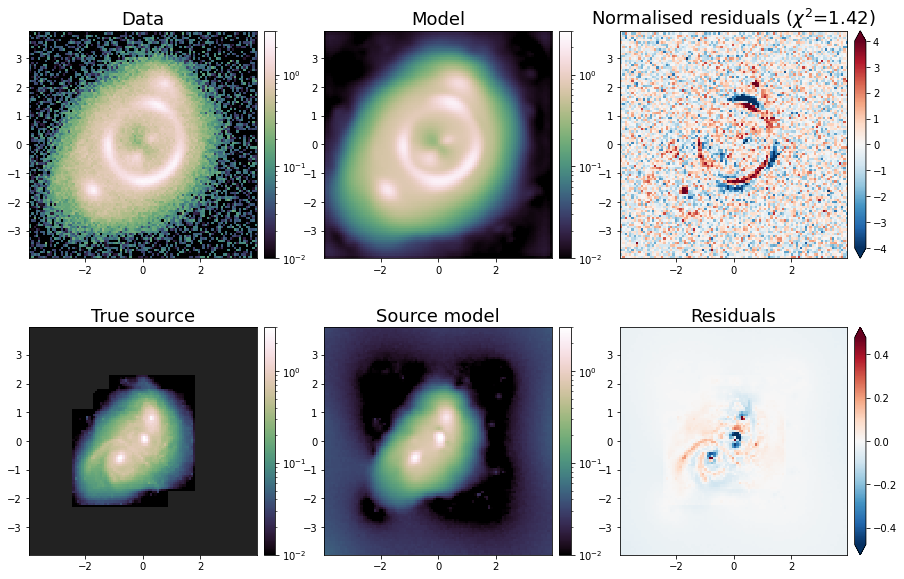

In [17]:
plotter.model_summary(lens_image_pixsource, kwargs_final_pixsource)

In [18]:
print_errors(kwargs_final_pixsource)

Error
-----
theta_E:   4.59 % (1.330841155341295 => 1.391953139696102)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        163.89 % (0.11111111111111108 => 0.2932150568176884)
e2:        0.07 [abs] (0.0 => -0.06989594699184563)
gamma_ext: 109.06 % (0.03 => 0.06271811773597713)
psi_ext:   95.22 % (0.7853981633974483 => 0.037537065922572416)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 3) Optimize pixelated source and smooth lens

In [19]:
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # unfix the center as well
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource.update_fixed(kwargs_fixed)

kwargs_true = {'kwargs_lens': kwargs_true_lens, 
                 'kwargs_source': [{'image': source_sim_data_res, 'x_coords': x_coords, 'y_coords': y_coords}],
                 'kwargs_lens_light': []}
p_true = copy.deepcopy(parameters_pixsource.kwargs2args(kwargs_true))
param_names = parameters_pixsource.names
print(p_true, param_names[0], param_names[-1], len(p_true))

[1.33084116 0.11111111 0.         ... 0.         0.         0.        ] s_0 s_9999 10007


In [20]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixsource.optax(max_iterations=max_iterations, 
                                init_learning_rate=init_learning_rate,
                                restart_from_init=False)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_final = parameters_pixsource.best_fit_values(as_kwargs=True)

Runtime: 25.19975519180298 s
Final loss: 2.10


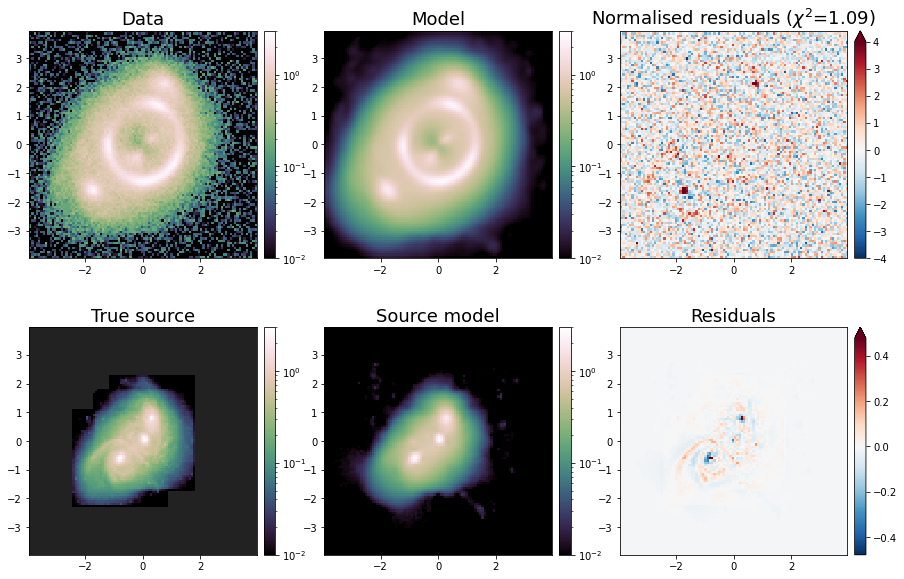

In [21]:
plotter.model_summary(lens_image_pixsource, kwargs_final_final)

In [22]:
print_errors(kwargs_final_final)

Error
-----
theta_E:   0.13 % (1.330841155341295 => 1.329145534693113)
center_x:  0.01 [abs] (0 => -0.011831887561790244)
center_y:  0.01 [abs] (0 => -0.005338883370019404)
e1:        5.03 % (0.11111111111111108 => 0.10551676275554293)
e2:        0.01 [abs] (0.0 => -0.005027941271674725)
gamma_ext: 7.83 % (0.03 => 0.027650696396537496)
psi_ext:   10.80 % (0.7853981633974483 => 0.8702017877814268)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 2) _bis_ Can residuals from step 1 be absorbed with potential perturbations?

In [23]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list, pixel_interpol='bilinear',
                                pixel_x_coords=x_coords, pixel_y_coords=y_coords)

# Lower resolution interpolation grid for pixelated potential
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

# update plotter with "true" potential grid
plotter.set_true_potential_perturbations(np.zeros((npix_lowres, npix_lowres)))

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI', 'PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list,
                            pixel_x_coords=x_coords_lowres, pixel_y_coords=y_coords_lowres)

lens_image_pixpot = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_init = {
    'kwargs_lens': [{}, {}] + [{'psi_grid': 1e-8 * jnp.ones((npix_lowres, npix_lowres))}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    # here we fix all smooth model parameters to step 2 results
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']) + [{}],
    'kwargs_source': copy.deepcopy(kwargs_final_allsmooth['kwargs_source']),
    'kwargs_lens_light': [{}],
}
parameters_pixpot = Parameters(lens_image_pixpot, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true_hybrid = {'kwargs_lens': kwargs_true_lens + [{'psi_grid': np.zeros((npix_lowres, npix_lowres))}], 
                 'kwargs_source': [{'image': source_sim_data_res}],
                 'kwargs_lens_light': []}
p_true_hybrid = copy.deepcopy(parameters_pixpot.kwargs2args(kwargs_true_hybrid))
param_names = parameters_pixpot.names
print(p_true_hybrid[0], param_names[0], param_names[-1], len(p_true_hybrid))

print("prior types:", parameters_pixpot.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixpot.bounds)

0.0 d_0 d_624 625
prior types: [None]
lower/upper bounds (for uniform priors): [-inf] [inf]


In [24]:
# load pre-compute potential noise map
dpsi_noise_map = np.load(f'data/SLITronomy/dpsi_1sigma_slitronomy_mock_single_{npix_lowres}px_fullmass_fullamp.npy')

loss_pixpot = Loss(data, lens_image_pixpot, parameters_pixpot, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_potential', 
                                            'l1_battle_potential'], 
                      regularization_strengths=[3, 3],
                      potential_noise_map=dpsi_noise_map)
optimizer_pixpot = Optimizer(loss_pixpot, parameters_pixpot)
print(optimizer_pixpot.loss(p_true_hybrid))

8.820839744150009


In [25]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixpot.optax(max_iterations=max_iterations, 
                             init_learning_rate=init_learning_rate,
                             restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_pixpot = parameters_pixpot.best_fit_values(as_kwargs=True)

Runtime: 23.63908314704895 s
Final loss: 2.45


delta_psi shift by mean values: 0.17849719950825693 0.0


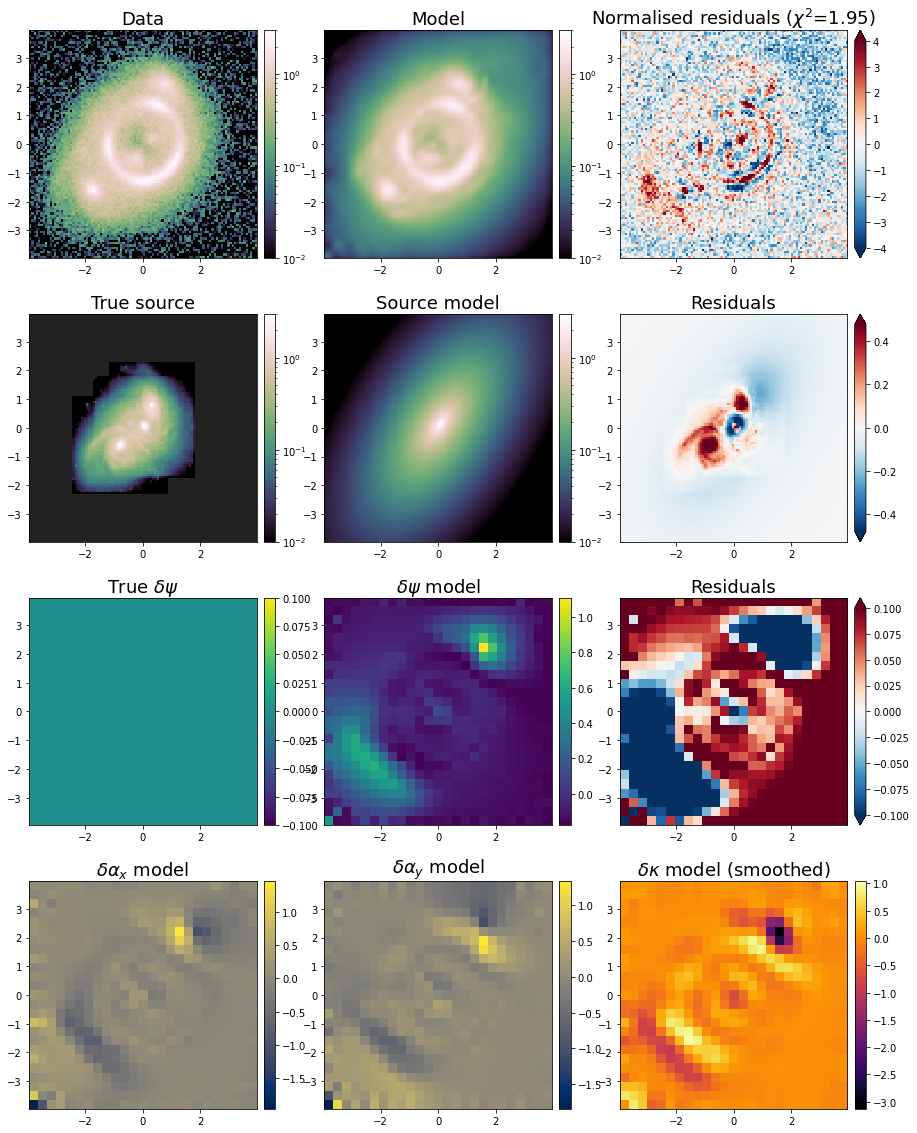

In [26]:
plotter.model_summary(lens_image_pixpot, kwargs_final_pixpot,
                      show_lens_mass=True, potential_mask=None,
                      with_mask=False, shift_potential='mean')

Model residuals worsen, and the best-fit potential perturbations are non-physical. In addition, using another optimizer (e.g. `optax`) instead if `scipy.minimize` leads to a completely different solution.

$\Longrightarrow$ Residuals from step 1 cannot be absorbed into potential perturbations!